In [15]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [16]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

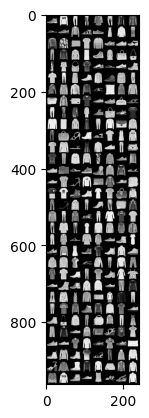

In [17]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [18]:
#testing data loader object
for x_image, label in train_loader:
    first_image = x_image[0]  
    first_label = labels[0]  
    break
    
len(first_image.flatten())

784

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self, input_size=1, output_size=10):
        super().__init__()
        #Lets do the same conv_group three times to make my life easy
        self.conv_group1 = nn.Sequential(
            nn.Conv2d(input_size, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),                                      #Lets use this as seen in slides, NOTE ONLY USE IMMEDIATELY AFTER CONVULTION OR FC LAYER
            nn.ReLU(),                                              
            nn.MaxPool2d(kernel_size=2, stride=2)              
        )
        #convultion should spit out 1 * 28 * 28 -> 32 * 14 * 14
        self.conv_group2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),              
            nn.BatchNorm2d(64),                                       #Lets just do this after every convultion filter
            nn.ReLU(),                                              
            nn.MaxPool2d(kernel_size=2, stride=2)                   
        )
        #convultion should then spit out 32 * 14 * 14 - > 64 * 6 * 6
        self.conv_group3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),             
            nn.BatchNorm2d(128),                                      
            nn.ReLU(),                                               
            nn.MaxPool2d(kernel_size=2, stride=2)                    
        )
        
        #convultion should then sputout 128 * 3 * 3 because the 7th pixel gets rounded down and isn't covered
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  
        self.fc2 = nn.Linear(256, output_size)   # Output layer (10 classes)
        
    def forward(self, x):
        # Apply the convolutional blocks sequentially
        x = self.conv_group1(x)
        x = self.conv_group2(x)
        x = self.conv_group3(x)
        
        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer (logits)
        
        return x


In [20]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    model.train()
    model.to(device)

    running_loss = 0
    correct = 0
    total = 0
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device),y_train.to(device)
        y_logit = model(X_train)

        #calculate the l2 norm for regularization
        l2_norm = torch.tensor(0.0).to(device)
        for param in model.parameters():
            l2_norm += torch.norm(param, p = 2)
            
        #find the loss
        loss = loss_fn(y_logit, y_train) + reg_param * l2_norm
        running_loss += loss
        #compute accuracy
        y_pred = torch.max(y_logit, 1)[1] 
        total += y_train.size(0)
        correct += (y_pred == y_train).sum().item()

        #update step from slides 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss = running_loss/ len(train_loader)
    train_acc = 100 * correct / total
    return train_loss, train_acc

In [21]:
# #TESTING CELL 

# import time
# start_time = time.time()

# test_model = ConvModel()
# test_loss_fn = nn.CrossEntropyLoss()

# #keeping note of tested hyper-params
# hyper_params = {.001: 0.95, .0001: 0.94, .01:.89, .0005: .96  }
# learning_rate = .0001 #tune as hyper parameter  

# #NOTE FOR TESTED VALUES .001 works best-around 95%, ANYTHING ABOVE .1 is not good, .0001 slow but not overstepping 94ish percent on train

# l2_norm = 0.01
# test_opt = torch.optim.Adam(test_model.parameters(), lr = learning_rate)
# test_dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for i in range(15):
#     print(f"Epoch {i}")
#     test_loss,test_acc = train_step(test_model, train_loader, test_loss_fn, test_opt, l2_norm, test_dev) 
# current_time = time.time()
# total_time = current_time - start_time

In [30]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    #should be the exact same as above but in eval mode and no optimizer bc we not updating gradients
    #going to copy and paste code from above and just change it to just have the data loader argument
    model.eval()
    model.to(device)
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_train, y_train in data_loader:
            X_train, y_train = X_train.to(device),y_train.to(device)
            y_logit = model(X_train)
    
            #calculate the l2 norm for regularization
            l2_norm = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l2_norm += torch.norm(param, p = 2)
                
            #find the loss
            loss = loss_fn(y_logit, y_train) + reg_param * l2_norm
            running_loss += loss
            #compute accuracy
            y_pred = torch.max(y_logit, 1)[1] 
            total += y_train.size(0)
            correct += (y_pred == y_train).sum().item()

    train_loss = running_loss/ len(data_loader)
    train_acc = 100 * correct / total
    print(train_loss, train_acc)
    return train_loss, train_acc

In [31]:
num_epochs = 20 #tweak here 
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    #Hyper Parameters to Tune
    learning_rate = 0.0001
    l2_norm = .01
    
    #Copied from simple classification part bc setup is same
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    conv_model = ConvModel().to(device)
    loss_func = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(conv_model.parameters(), lr = learning_rate)
    
    train_acc_list = []
    train_loss_list = []
    valid_acc_list = []
    valid_loss_list = []
    test_acc_list = []
    test_loss_list = []

    torch.manual_seed(random_seed)  # do not change this

    for i in range(num_epochs):
        #train
        train_loss, train_acc = train_step(conv_model, train_loader,loss_func, opt, l2_norm, device)
        train_loss_list.append(train_loss.item()) #append the item for all of them bc they're returning as tensors
        train_acc_list.append(train_acc)

        #validation 
        valid_loss, valid_acc = evaluation_step(conv_model,valid_loader, loss_func, l2_norm, device)
        valid_loss_list.append(valid_loss.item())
        valid_acc_list.append(valid_acc)

        #test
        test_loss, test_acc = evaluation_step(conv_model,test_loader, loss_func, l2_norm, device)
        test_loss_list.append(test_loss.item())
        test_acc_list.append(test_acc)
    return conv_model, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list, test_loss_list, test_acc_list

In [32]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    epochs = np.linspace(1, len(train_accuracies), len(train_accuracies))
    plt.plot(epochs,train_accuracies, label = "Train Accuracy", c= "red")
    plt.plot(epochs,valid_accuracies, label = "Valid Accuracy", c = "blue")
    plt.plot(epochs,test_accuracies, label = "Test Accuracy", c = "green")
    plt.xlabel("Epoch Number"); plt.ylabel("Accuracy %"); plt.title("Accuracy in Train vs Test Sets")
    plt.legend()

In [33]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
    epochs = np.linspace(1, len(train_losses), len(test_losses))
    plt.plot(epochs,train_losses, label = "Train Set Losses", c= "red")
    plt.plot(epochs,valid_accuracies, label = "Validation Set Losses", c = "blue")
    plt.plot(epochs,test_losses, label = "Test Set Losses", c = "green")
    plt.xlabel("Epoch Number"); plt.ylabel("Cross Entropy Loss"); plt.title("Cross Entropy in Train vs Test Sets")
    plt.legend()

In [34]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

tensor(0.9404, device='cuda:0') 85.48333333333333
tensor(0.9582, device='cuda:0') 84.73
tensor(0.8422, device='cuda:0') 88.29166666666667
tensor(0.8675, device='cuda:0') 87.26
tensor(0.8010, device='cuda:0') 89.4
tensor(0.8257, device='cuda:0') 88.64
tensor(0.8045, device='cuda:0') 88.71666666666667
tensor(0.8249, device='cuda:0') 88.25
tensor(0.7632, device='cuda:0') 90.23333333333333
tensor(0.7875, device='cuda:0') 89.79
tensor(0.7585, device='cuda:0') 90.425
tensor(0.7825, device='cuda:0') 89.75
tensor(0.7428, device='cuda:0') 90.93333333333334
tensor(0.7711, device='cuda:0') 90.01
tensor(0.7306, device='cuda:0') 91.25833333333334
tensor(0.7546, device='cuda:0') 90.76
tensor(0.7355, device='cuda:0') 90.90833333333333
tensor(0.7602, device='cuda:0') 90.56
tensor(0.7248, device='cuda:0') 91.16666666666667
tensor(0.7480, device='cuda:0') 90.72
tensor(0.7212, device='cuda:0') 91.075
tensor(0.7487, device='cuda:0') 90.69
tensor(0.7214, device='cuda:0') 91.14166666666667
tensor(0.7467, de

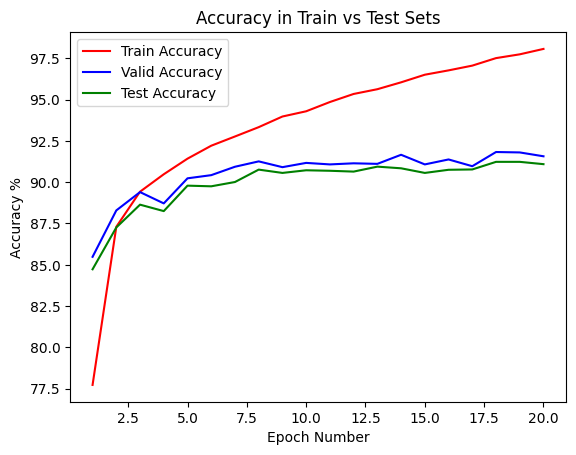

In [35]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

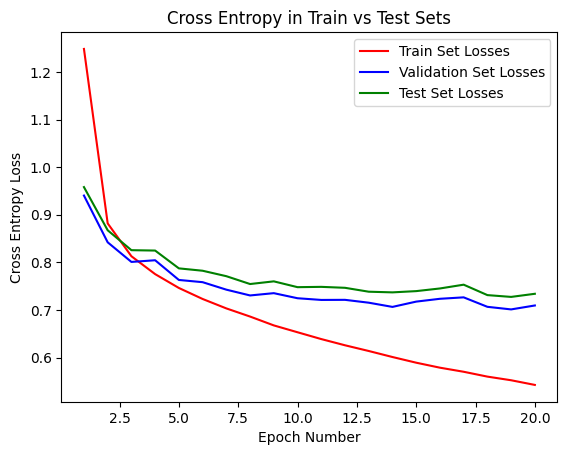

In [36]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)